# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

file_name = 'OnlineRetail.csv'
file_path = os.path.abspath(file_name)
print("Absolute File Path:", file_path)


In [3]:
file_path = '/Users/aindreeaarya/new_MLA_task2code/OnlineRetail.csv'

# Import the CSV file into a DataFrame
df = pd.read_csv(file_path, encoding='ISO-8859-1')

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Data Exploration

In [4]:
#  Dataset Overview
print("Dataset Overview:")
print(df.info())
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000

In [5]:
# Check for missing values

print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Apply linear interpolation to the numerical columns only

In [6]:

df['Quantity'] = df['Quantity'].interpolate(method='linear')
df['UnitPrice'] = df['UnitPrice'].interpolate(method='linear')

# For CustomerID and any other numerical columns with missing values, apply interpolation if needed
df['CustomerID'] = df['CustomerID'].interpolate(method='linear')

# If you want to interpolate all numerical columns at once, you can use:
# df = df.interpolate(method='linear', limit_direction='forward')

# For non-numerical columns (like Description, InvoiceNo, Country), you can handle them separately.
# For example, you could use forward fill for these columns:
df['Description'] = df['Description'].fillna(method='ffill')
df['InvoiceNo'] = df['InvoiceNo'].fillna(method='ffill')
df['Country'] = df['Country'].fillna(method='ffill')

# Check the result
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


## Check the distribution of 'Quantity' and 'UnitPrice' to identify outliers

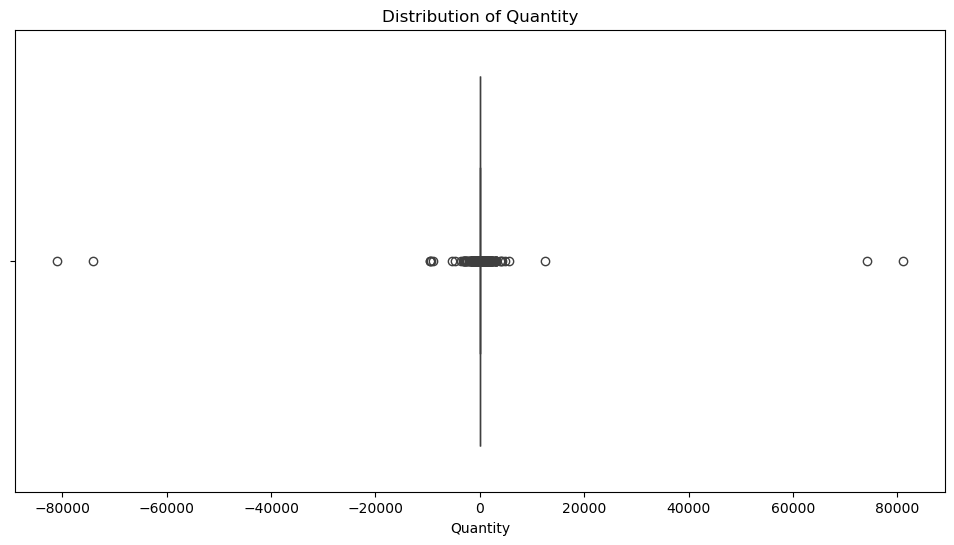

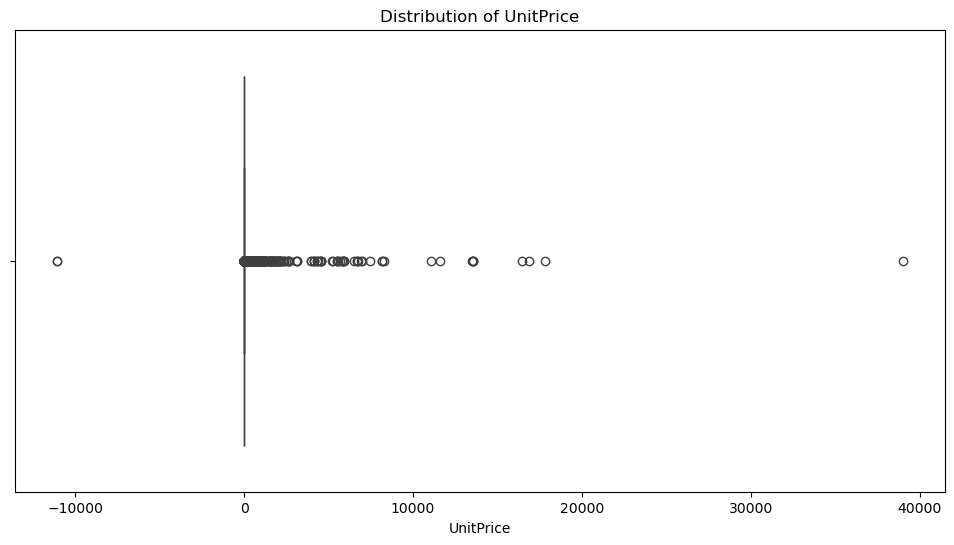

In [7]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Quantity', data=df)
plt.title('Distribution of Quantity')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='UnitPrice', data=df)
plt.title('Distribution of UnitPrice')
plt.show()


# Data Preprocessing

In [8]:


# Drop rows with missing values in essential columns like 'InvoiceNo', 'CustomerID', 'Quantity', 'UnitPrice'
df = df.dropna(subset=['InvoiceNo', 'CustomerID', 'Quantity', 'UnitPrice'])

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Remove negative quantities (which are likely returns)
df = df[df['Quantity'] > 0]

# Create new features: TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Remove outliers in the 'UnitPrice' and 'Quantity' columns using IQR method
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['UnitPrice'] >= Q1 - 1.5 * IQR) & (df['UnitPrice'] <= Q3 + 1.5 * IQR)]

Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Quantity'] >= Q1 - 1.5 * IQR) & (df['Quantity'] <= Q3 + 1.5 * IQR)]


In [9]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [10]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# EDA

## Distribution of Total Price (histogram)

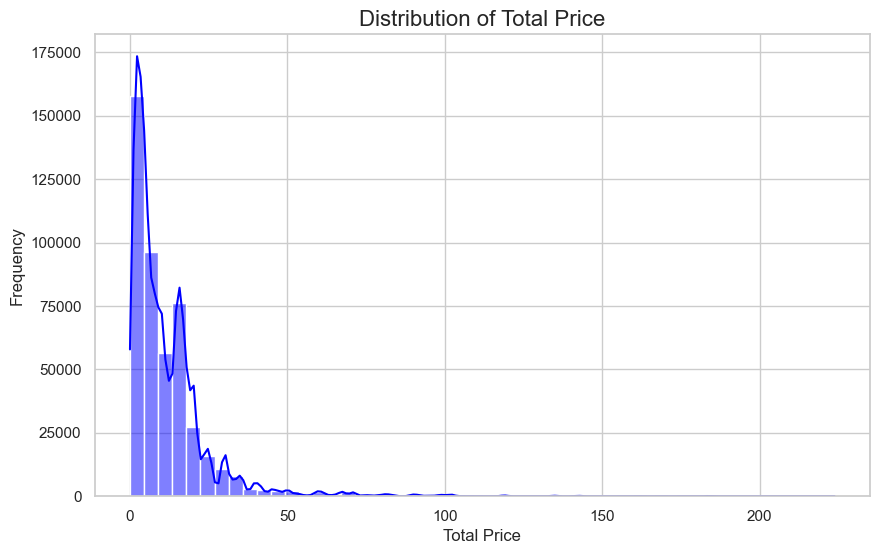

In [11]:
# Set plot style
sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], kde=True, color='blue', bins=50)
plt.title('Distribution of Total Price', fontsize=16)
plt.xlabel('Total Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

## Total sales by Country (bar plot)

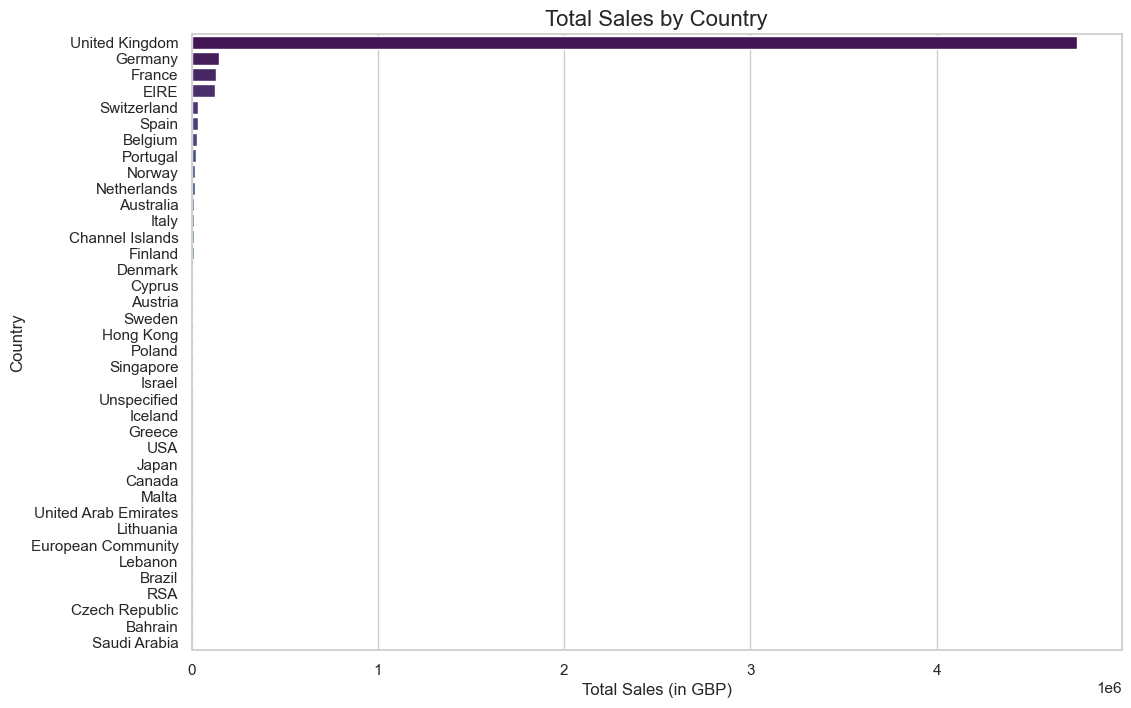

In [12]:

country_sales = df.groupby('Country')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='TotalPrice', y='Country', data=country_sales, palette='viridis')
plt.title('Total Sales by Country', fontsize=16)
plt.xlabel('Total Sales (in GBP)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

## Relationship between Quantity and TotalPrice (scatter plot)

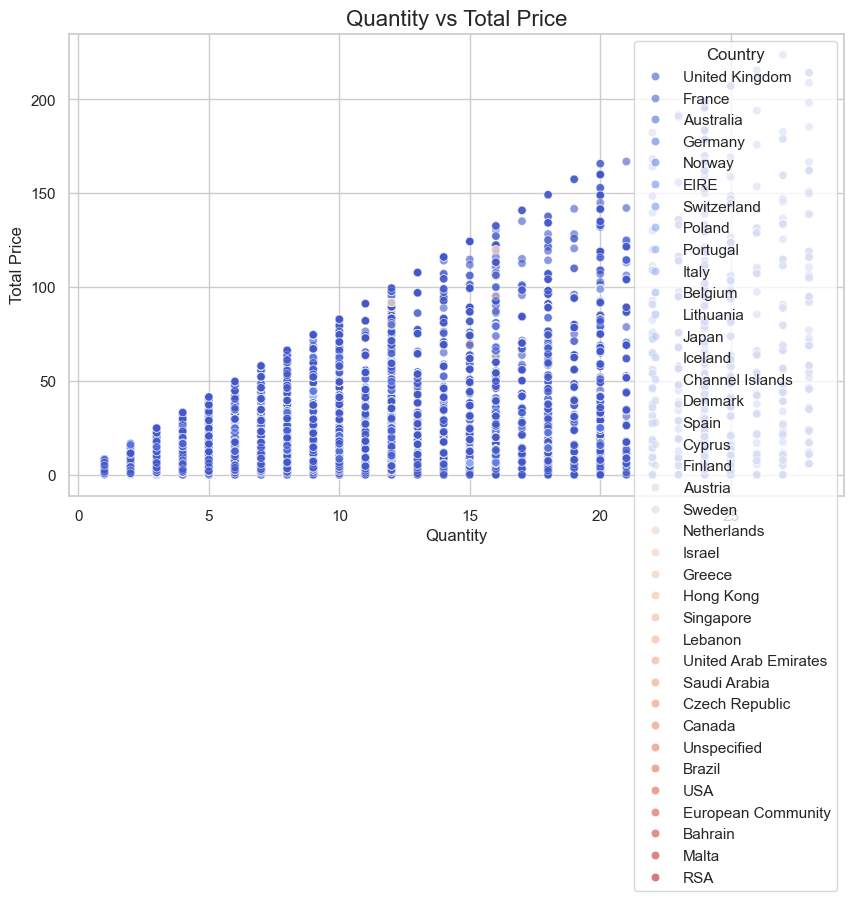

In [13]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Quantity', y='TotalPrice', hue='Country', palette='coolwarm', alpha=0.6)
plt.title('Quantity vs Total Price', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Total Price', fontsize=12)
plt.show()

## Top 10 most sold items (bar plot)

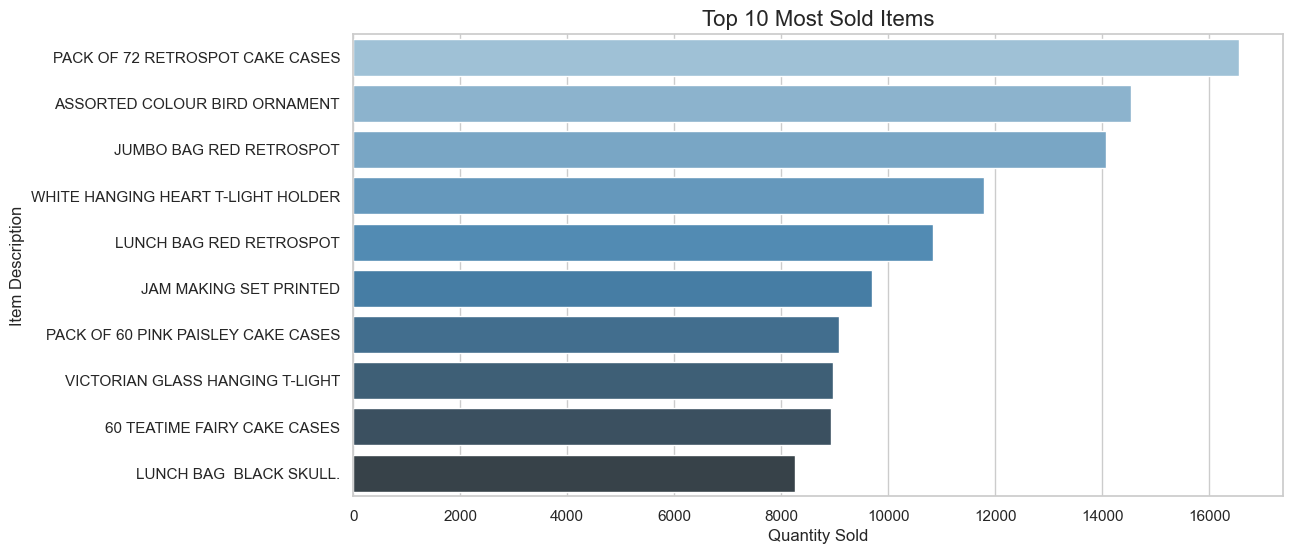

In [14]:

top_items = df.groupby('Description')['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_items, palette='Blues_d')
plt.title('Top 10 Most Sold Items', fontsize=16)
plt.xlabel('Quantity Sold', fontsize=12)
plt.ylabel('Item Description', fontsize=12)
plt.show()

## Heatmap of Correlations (Correlation of numerical features)

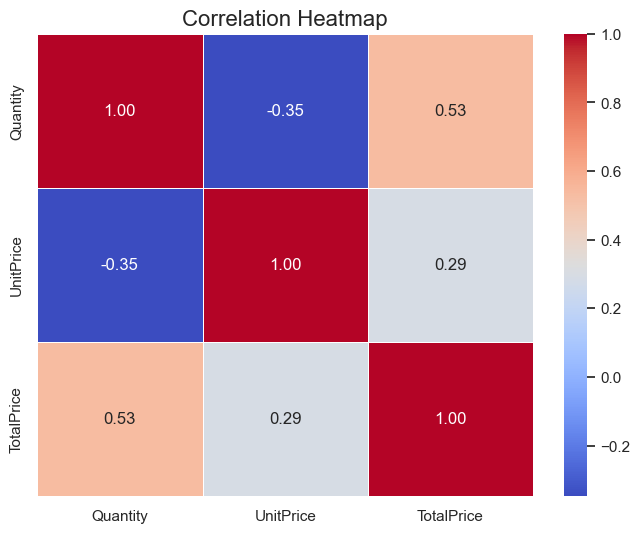

In [15]:

corr_matrix = df[['Quantity', 'UnitPrice', 'TotalPrice']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## Boxplot for TotalPrice by Country

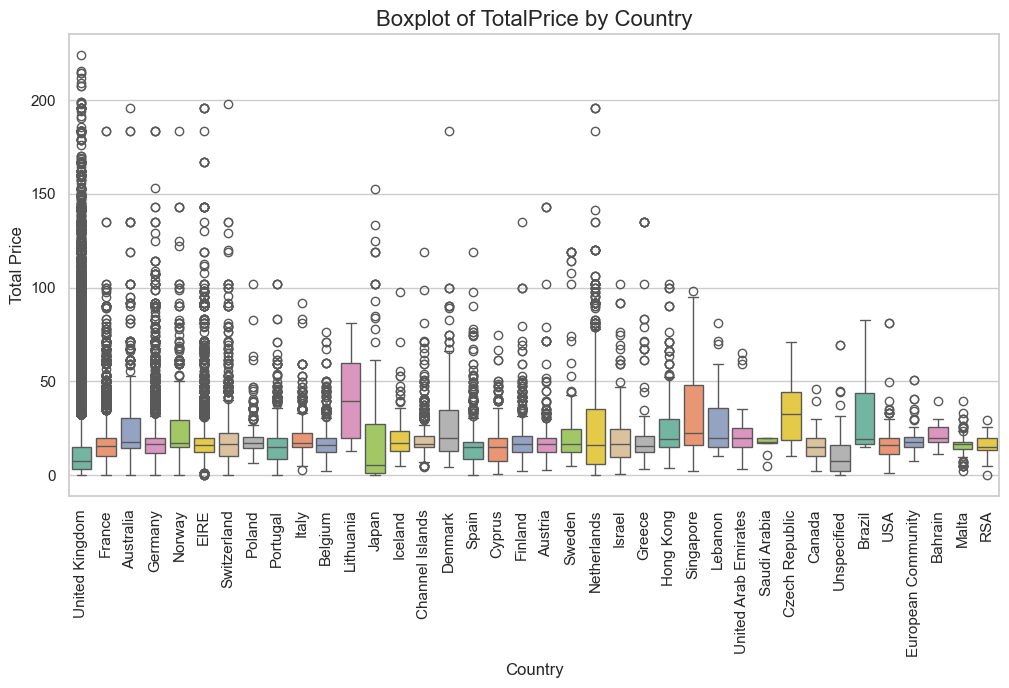

In [16]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='TotalPrice', data=df, palette='Set2')
plt.title('Boxplot of TotalPrice by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Price', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Customer Purchase Patterns (number of items purchased per customer)

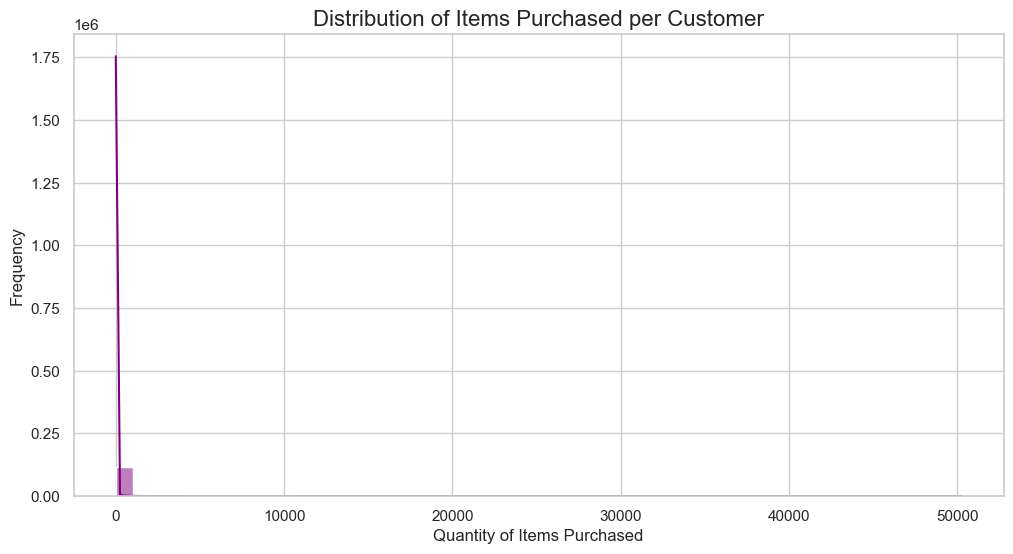

In [17]:

customer_purchase = df.groupby('CustomerID')['Quantity'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.histplot(customer_purchase['Quantity'], kde=True, color='purple', bins=50)
plt.title('Distribution of Items Purchased per Customer', fontsize=16)
plt.xlabel('Quantity of Items Purchased', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [18]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# Models for clustering

In [19]:
# Create a new dataframe for clustering with 'CustomerID', 'TotalPrice', and 'Quantity'
df_cluster = df[['CustomerID', 'TotalPrice', 'Quantity']].drop_duplicates()

# Standardize the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster[['TotalPrice', 'Quantity']])

# Apply PCA for dimensionality reduction (optional but helps visualize clustering)
pca = PCA(n_components=2)
df_cluster_pca = pca.fit_transform(df_cluster_scaled)

## KMeans

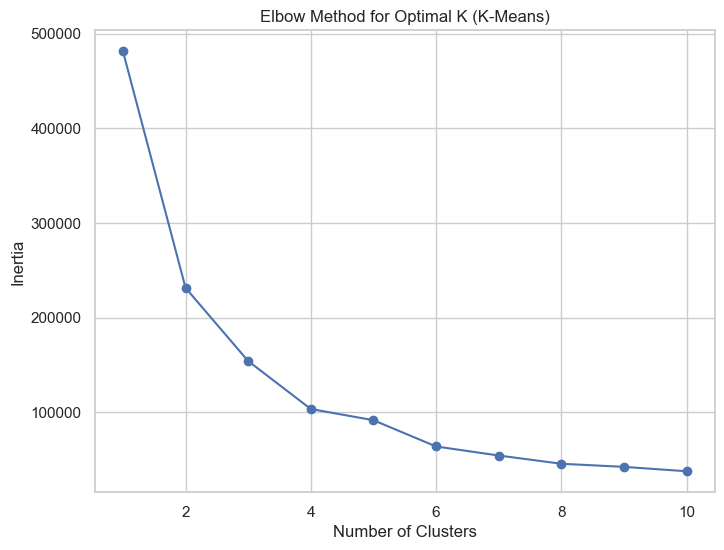

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Choosing the optimal number of clusters using the Elbow method (K-Means)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method for K-Means
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# From the Elbow plot, we can select k=4 (assuming this looks like the optimal choice)
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['KMeans_Cluster'] = kmeans.fit_predict(df_cluster_scaled)


## GaussianMixture

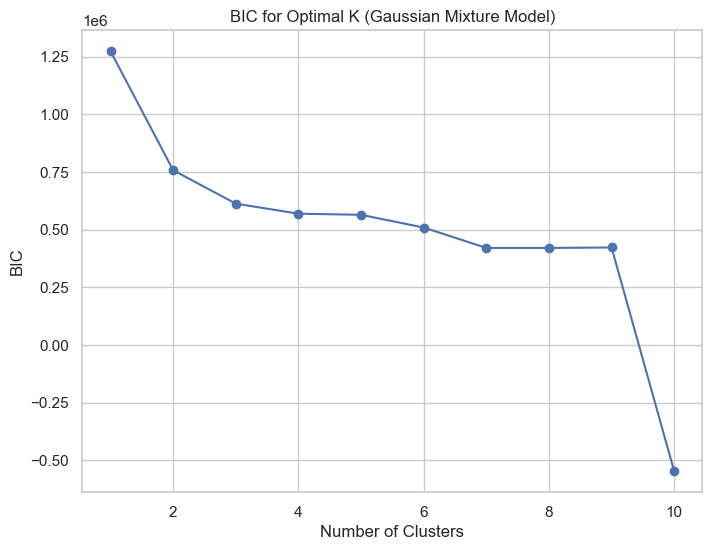

In [21]:
from sklearn.mixture import GaussianMixture

# Step 2: Choosing the optimal number of clusters using BIC (Bayesian Information Criterion) for GMM
bic_scores = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_cluster_scaled)
    bic_scores.append(gmm.bic(df_cluster_scaled))

# Plot BIC scores (Elbow Method for GMM)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), bic_scores, marker='o')
plt.title('BIC for Optimal K (Gaussian Mixture Model)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()

# From the BIC plot, we can select k=4 (assuming this looks like the optimal choice)
gmm = GaussianMixture(n_components=4, random_state=42)
df_cluster['GMM_Cluster'] = gmm.fit_predict(df_cluster_scaled)


## Evaluation of model

In [22]:
from sklearn.metrics import silhouette_score

# Step 3: Calculate Silhouette Score for both clustering algorithms

# K-Means Silhouette Score
kmeans_silhouette = silhouette_score(df_cluster_scaled, df_cluster['KMeans_Cluster'])

# GMM Silhouette Score
gmm_silhouette = silhouette_score(df_cluster_scaled, df_cluster['GMM_Cluster'])

# Print Silhouette Scores
print(f"Silhouette Score for K-Means Clustering: {kmeans_silhouette:.4f}")
print(f"Silhouette Score for GMM Clustering: {gmm_silhouette:.4f}")


Silhouette Score for K-Means Clustering: 0.5805
Silhouette Score for GMM Clustering: 0.4192
